In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
Pkg.instantiate()
using ForwardDiff
using Test
using RobotZoo: PlanarQuadrotor
using RobotDynamics
using LinearAlgebra
using StaticArrays
using Statistics
using Plots
using Printf
using JLD2
const jldir = joinpath(dirname(@__DIR__),"test")

const FD = ForwardDiff;

test_dict = load(joinpath(jldir,"q1.jld2"))

include("quadrotor.jl");

  Activating environment at `~/devel/optimal_control/hw3_solutions/Project.toml`
Precompiling project...
  ✓ AssetRegistry
  ✓ Mux
  ✓ WebIO
  ✓ JSExpr
  ✓ Blink
  ✓ MeshCat
  6 dependencies successfully precompiled in 9 seconds (179 already precompiled)


# Question 1: Iterative LQR (50 pts)
In this problem you'll implement iterative LQR (ilQR), the Gauss-Newton approximation of differential dynamic programming (DDP). You'll use it to generate trajectories for a planar quadrotor, including a flip. In the last part of the problem, you'll track the trajectory to make it robust to wind.

## The Model
We'll be using the same planar quadrotor model we saw in class. The dynamics are fairly simple:

$$ 
x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix} v_x \\ v_z \\ \omega \\ 
\frac{1}{m} (u_1 + u_2) \sin{\theta} \\
\frac{1}{m} (u_1 + u_2) \cos{\theta} - g \\
\frac{l}{J} (u_2 - u_1) 
\end{bmatrix}
$$
with the following model parameters:
* $m$: mass (kg)
* $J$: moment of inertia
* $l$: distance between motors

In [2]:
model = PlanarQuadrotor()
const x0    = [-3, 1.0, 0, 0, 0, 0]                    # initial state
const xgoal = [+3, 1.0, 0, 0, 0, 0]                    # goal state
const nx = 6 
const nu = 2
const uhover = fill(0.5*1.0 * 9.81, nu) 

const Q = Diagonal(([ones(3) ; fill(0.1, 3)]))
const R = Diagonal(fill(1e-2, nu))
const Qf = Diagonal(fill(1e2, nx));

const dt = 0.025 
const N = 61

61

In [4]:
"""
Calculate the continuous time dynamics ẋ = f(x,u), x is a vector of length 6, u is a vector of length 2.

returns ẋ
"""

function dynamics(x,u)
    # planar quadrotor dynamics
    
    # parameters
    mass = 1.0 
    g = 9.81
    ℓ = 0.3 
    J = 0.2*mass*ℓ^2

     # unpack state
    px,pz,θ,vx,vz,ω = x    
    return [vx,vz,ω,(1/mass)*(u[1] + u[2])*sin(θ), (1/mass)*(u[1] + u[2])*cos(θ) - g, (ℓ/(2*J))*(u[2]-u[1])]
end

"""
Integrates the dynamics ODE 1 dt forward, x_{k+1} = rk4(x_k,u_k,dt).

returns x_{k+1}
"""
function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x,u)
    k2 = dt*dynamics(x + k1/2,u)
    k3 = dt*dynamics(x + k2/2,u)
    k4 = dt*dynamics(x + k3,u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

"""
uses forward diff to get the following jacobians of the above discrete dynamics function (rk4):
drk4/dx = A 
drk4/du = B
"""
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = FD.jacobian(_x -> rk4(_x,u,dt),x)
    B = FD.jacobian(_u -> rk4(x,_u,dt),u)
    return A,B
end

dynamics_jacobians

# Part (a): Implement iLQR

## LQR Cost Function
Here you will create functions for calculating the costs of states/controls as well as whole trajectories. Our cost function can broken up as the following:

**for every time step that isn't the last one**

$$J(x,u) = \frac{1}{2}(x - x_{ref})^TQ(x - x_{ref}) + \frac{1}{2}(u -u_{ref})^TR(u-u_{ref})$$

**for the last time step**

$$J_N(x) = \frac{1}{2}(x - x_{ref})^TQ_f(x - x_{ref})$$

Since our whole cost function for the entire trajectory is the following:

$$\ell(X,U) = \bigg[ \sum_{i=1}^{N-1} J(x_k,u_k) \bigg] + J_N(x_N)$$

In [5]:
# cost expansion 
function stage_cost(x,u,xref,uref)
    # LQR cost at each knot point (depends on both x and u)
    
    # TODO
    J = 0.0
    
    
    return J
end

function term_cost(x,xref)
    # LQR terminal cost (depends on just x)
    
    # TODO
    J = 0.0 
    
    return J
end

function trajectory_cost(X,U,Xref,Uref)
    # calculate the cost of a given trajectory 

    # TODO
    J = 0.0
    
    return J
end
        
function stage_cost_expansion(x,u,xref,uref)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    
    # TODO
    Jxx = zeros(nx,nx)
    Jx = zeros(nx)
    Juu = zeros(nu,nu)
    Ju = zeros(nu)
    
    return Jxx, Jx, Juu, Ju
end

function term_cost_expansion(x,xref)
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ
    
    # TODO
    Jxx = zeros(nx,nx)
    Jx = zeros(nx)
    
    return Jxx, Jx
end

term_cost_expansion (generic function with 1 method)

In [6]:
using Random
@testset "cost tests" begin 

    Xref = [copy(xgoal) for i = 1:N]
    Uref = [copy(uhover) for i = 1:N-1]
    
    X = [copy(x0) for i = 1:N]
    U = deepcopy(Uref)
    
    # costs 
    J1 = stage_cost(X[1],U[1],Xref[1],Uref[1])
    J2 = term_cost(X[N],Xref[N])
    J3 = trajectory_cost(X,U,Xref,Uref)
    
    @test stage_cost(X[1],U[1],Xref[1],Uref[1]) ≈  test_dict["J1"] atol = 1e-10
    @test term_cost(X[N],Xref[N]) ≈ test_dict["J2"]  atol = 1e-10
    @test trajectory_cost(X,U,Xref,Uref) ≈ test_dict["J3"] atol = 1e-8
    
    # cost derivatives
    Jxx, Jx, Juu, Ju = stage_cost_expansion(X[4],U[4],Xref[4],Uref[4])
    
    @test vec(Jxx) ≈ vec(test_dict["Jxx"]) atol =1e-10
    @test Jx ≈ test_dict["Jx"] atol = 1e-8
    @test vec(Juu) ≈ vec(0.01*I(nu)) atol = 1e-8
    @test Ju ≈ test_dict["Ju"] atol = 1e-8
    
    Jxx2, Jx2 = term_cost_expansion(X[8],Xref[8])
    
    @test vec(Jxx2) ≈ vec(test_dict["Jxx2"]) atol = 1e-8
    @test Jx2 ≈ vec(test_dict["Jx2"]) atol = 1e-8;
    
end

Test Summary: | Pass  Total
cost tests    |    9      9


Test.DefaultTestSet("cost tests", Any[], 9, false, false)

## Backward Pass
You will now implement the backwards pass of iLQR. Remember that iLQR has two parts, a backward pass and a forward pass.  The backward pass is where feedforward controls `d` and feedback gains `K` are solved for. 

Hint: initialize $\Delta J$ as 0, and during each step of the backwards pass, add $g_u^Td_k$ to it. 

In [7]:
"""
backward pass for iLQR. Inputs are 
    X - current trajectory              Vector{Vector}
    U - current control                 Vector{Vector}
    Xref - trajectory we want to track  Vector{Vector}
    Uref - control we want to track     Vector{Vector}

We will perform the backwards recursion without any regularization. Store the expected cost 
decrease in ΔJ and return the following 
    d - feedforward control             Vector{Vector}
    K - feedback gain matrices          Vector{Matrix}
    P - cost to go quadratic term       Vector{Matrix}
    ΔJ - expected cost decrease         Float
"""

function backward_pass(X,U,Xref,Uref)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
    p = [zeros(nx) for i = 1:N]      # cost to go linear term 
    d = [zeros(nu) for i = 1:N-1]    # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
    ΔJ = 0.0                         # expected cost decrease


    
    # TODO: implement the backward pass 
    
    # terminal cost expansion
    
    
    for k = (N-1):(-1):1
        
        # dynamics jacobians 
    
        
        # cost expansion 
        
        
        # action value expansion 
        
        
        # calculate d and K 
        
        
        # update p and P 
        
        
        # add to ΔJ 
        
    end
    
    return d, K, P, ΔJ
end

backward_pass (generic function with 1 method)

In [8]:
function test_vec(var,tru;atol = 1e-6)
    for i = 1:length(tru)
        name = "element #"*string(i)
        @testset "$name" begin @test isapprox(vec(var[i]), vec(tru[i]),atol = atol); end;
    end
    return nothing
end

@testset "backward pass" begin 
    
    X = test_dict["X"]
    U = test_dict["U"]
    Xref = test_dict["Xref"]
    Uref = test_dict["Uref"]
    
    d, K, P, ΔJ = backward_pass(X,U,Xref,Uref)
    
    test_vec(d,test_dict["d"],atol = 1e-3);
    test_vec(K,test_dict["K"],atol = 1e-3);
    test_vec(P,test_dict["P"],atol = 1e-3);
    @test ΔJ ≈ test_dict["ΔJ"] atol = 1e-3
    
end
    
    

Test Summary: | Pass  Total
backward pass |  182    182


Test.DefaultTestSet("backward pass", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false), Test.DefaultTestSet("element #4", Any[], 1, false, false), Test.DefaultTestSet("element #5", Any[], 1, false, false), Test.DefaultTestSet("element #6", Any[], 1, false, false), Test.DefaultTestSet("element #7", Any[], 1, false, false), Test.DefaultTestSet("element #8", Any[], 1, false, false), Test.DefaultTestSet("element #9", Any[], 1, false, false), Test.DefaultTestSet("element #10", Any[], 1, false, false)  …  Test.DefaultTestSet("element #52", Any[], 1, false, false), Test.DefaultTestSet("element #53", Any[], 1, false, false), Test.DefaultTestSet("element #54", Any[], 1, false, false), Test.DefaultTestSet("element #55", Any[], 1, false, false), Test.DefaultTestSet("element #56", Any[], 1, false, false), Test.DefaultTestSet("element #57", Any[], 1, false, false), Test.

## Forward Pass
Next we will build out forward pass function. This is where we do a forward simulation with the new `d` and `K`'s from the backwards pass, and do a backtracking line search on $\alpha$ to ensure we see a neccessary decrease. During our linesearch, we accept our new trajectory/control if the following Armijo condition is satsified:

$$ J_n < J - 0.01\alpha\Delta J$$

In [9]:
"""
forward pass of iLQR

inputs:
    X - current trajectory              Vector{Vector}
    U - current control                 Vector{Vector}
    Xref - trajectory we want to track  Vector{Vector}
    Uref - control we want to track     Vector{Vector}
    K - feedback gain matrices          Vector{Matrix}
    d - feedforward control             Vector{Vector}
    ΔJ - expected cost decrease         Float

outputs:
    Xn - new trajectory                 Vector{Vector}
    Un - new control                    Vector{Vector}
    Jn - new trajectory cost            Float
    α  - step size taken                Float
"""

function forward_pass(X,U,Xref,Uref,K,d,ΔJ; max_linesearch_iters = 10)
    
    # new trajectory Xn Un 
    Xn = deepcopy(X)
    Un = deepcopy(U)
    
    # step length (we start at 1)
    α = 1.0 
    
    # TODO implement forward pass 
    
    # calculate cost of current trajectory X U 
    J = 0.0 
    
    # backtracking line search
    for i = 1:max_linesearch_iters
        
        # simulate the new trajectory and save it in Xn and Un 
        
        # calcualte cost of Xn and Un 
        Jn = 0.0 
        
        # use armijo line search condition to decide if you accept the decrease 
        
        # if you accept 
        #    return Xn, Un, Jn, α
        
        # if you don't, cut th step length in half 
        
    end
    
    error("forward pass failed")
end

forward_pass (generic function with 1 method)

In [10]:
@testset "forward pass" begin 
    
    Xref = [copy(xgoal) for i = 1:N]
    Uref = [copy(uhover) for i = 1:N-1]
    
    X = [copy(x0) for i = 1:N]
    U = deepcopy(Uref)
    
    d, K, P, ΔJ = backward_pass(X,U,Xref,Uref)
    
    Xn, Un, Jr, α = forward_pass(X,U,Xref,Uref,K,d,ΔJ)
    
    test_vec(Xn, test_dict["Xn"])
    test_vec(Un, test_dict["Un"])
    @test Jr ≈ test_dict["Jr"] atol = 1e-6
    @test α ≈ test_dict["α"]  atol = 1e-6

end

Test Summary: | Pass  Total
forward pass  |  123    123


Test.DefaultTestSet("forward pass", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false), Test.DefaultTestSet("element #4", Any[], 1, false, false), Test.DefaultTestSet("element #5", Any[], 1, false, false), Test.DefaultTestSet("element #6", Any[], 1, false, false), Test.DefaultTestSet("element #7", Any[], 1, false, false), Test.DefaultTestSet("element #8", Any[], 1, false, false), Test.DefaultTestSet("element #9", Any[], 1, false, false), Test.DefaultTestSet("element #10", Any[], 1, false, false)  …  Test.DefaultTestSet("element #51", Any[], 1, false, false), Test.DefaultTestSet("element #52", Any[], 1, false, false), Test.DefaultTestSet("element #53", Any[], 1, false, false), Test.DefaultTestSet("element #54", Any[], 1, false, false), Test.DefaultTestSet("element #55", Any[], 1, false, false), Test.DefaultTestSet("element #56", Any[], 1, false, false), Test.D

## iLQR Algorithm
Now we are going to put it all together, we are given an initial condition `x0` and an unitial control input history `U`, and a reference trajectory `Xref` and `Uref`. We will start by doing a forward simulation starting from `x0` using `U` as the control input, creating `X`. Then we will start our main loop. In each iteartion, we do the following:

- backward pass 
- check termination criteria 
- forward pass 


In [11]:
"""
iLQR will combine the backward and forward passes for the complete iLQR algorithm. We will classify 
convergence as when the maximum norm of each feedforward control input in d is below atol. (this is given)

inputs:
    x0 - initial condition                             Vector
    U - initial control history                        Vector{Vector}
    Xref - reference trajectory we are trying to track Vector{Vector}
    Uref - reference controls we are trying to track   Vector{Vector}

outputs:
    X - optimal trajectory                             Vector{Vector}
    U - optimal control trajectory                     Vector{Vector}
    K - feedback gain matrices                         Vector{Matrix}
    P - cost to go hessians                            Vector{Matrix}
    iter - iterations it took to converge              Int
"""
function iLQR(x0,U,Xref,Uref;atol=1e-5,max_iters = 100)
    
    # inital logging stuff 
    @printf "iter     J           ΔJ        |d|         α\n"
    @printf "-----------------------------------------------\n"
    
    # allocate X 
    X = [zeros(nx) for i = 1:N]
    
    # initial rollout (fill in X starting at x0 applying U)
    
    for iter = 1:max_iters
        
        # backward pass 
        
        # termination criteria
        if maximum(norm.(d))<atol
            return X,U,K,P,iter
        end
        
        # forward pass 
        
        # logging
        @printf("%3d   %10.3e  %9.2e  %9.2e  % 6.4f\n",
          iter, J, ΔJ, maximum(norm.(d)), α)
        
    end
    error("ilqr reached max iters")
        
end
        

iLQR

## Part (b): Simple trajectory
Use your iLQR solver to move the quadrotor from the initial state to the goal state.

In [12]:
# reference trajectory (we just want to track the goal state and hover control)
Xrefline = [copy(xgoal) for i = 1:N]
Urefline = [copy(uhover) for i = 1:N-1]

# call iLQR
Xline,Uline,Kline,Pline, iterline = iLQR(x0,Urefline,Xrefline,Urefline);

iter     J           ΔJ        |d|         α
-----------------------------------------------
  1    7.572e+02   4.55e+03   7.22e+01   1.0000
  2    5.552e+02   5.79e+02   4.53e+01   1.0000
  3    4.908e+02   1.62e+02   2.77e+01   1.0000
  4    4.823e+02   2.60e+01   1.69e+01   1.0000
  5    4.798e+02   7.97e+00   8.00e+00   1.0000
  6    4.791e+02   2.57e+00   4.86e+00   1.0000
  7    4.789e+02   1.07e+00   2.95e+00   1.0000
  8    4.788e+02   4.47e-01   1.92e+00   1.0000
  9    4.788e+02   2.16e-01   1.30e+00   1.0000
 10    4.788e+02   9.95e-02   8.51e-01   1.0000
 11    4.787e+02   4.95e-02   6.14e-01   1.0000
 12    4.787e+02   2.38e-02   4.12e-01   1.0000
 13    4.787e+02   1.19e-02   2.99e-01   1.0000
 14    4.787e+02   5.81e-03   2.05e-01   1.0000
 15    4.787e+02   2.89e-03   1.47e-01   1.0000
 16    4.787e+02   1.42e-03   1.02e-01   1.0000
 17    4.787e+02   7.06e-04   7.24e-02   1.0000
 18    4.787e+02   3.49e-04   5.06e-02   1.0000
 19    4.787e+02   1.73e-04   3.58e-02   1.

In [13]:
@testset "iLQR" begin 
    @test trajectory_cost(Xline,Uline,Xrefline,Urefline) <4.8e2
    @test iterline < 50
    @test iterline > 30
    @test norm(Xline[end] - xgoal) < 0.2
    @test maximum(maximum.(Uline)) < 40
    @test maximum(maximum.(Uline)) > 30
    @test minimum(minimum.(Uline)) < -30
    @test minimum(minimum.(Uline)) > -40
    
    d, K, P, ΔJ = backward_pass(Xline,Uline,Xrefline,Urefline)
    
    @test ΔJ < 1e-4
    @test maximum(norm.(d)) < 1e-3
end

Test Summary: | Pass  Total
iLQR          |   10     10


Test.DefaultTestSet("iLQR", Any[], 10, false, false)

In [14]:
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /Users/kevintracy/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [15]:
visualize!(vis, model, dt*(N-1), Xline)

## Part (c): Generate Cost function for Flip
Generate a reference trajectory for the cost function. Since we're designing it by hand we'll do something simple. Complete the function below to generate a trajectory that does the following:
* 0.0-0.5 sec: Moves linearly from -3 to 0 in x, $p_z=1$, $\omega=0$
* 0.5-1.0 sec: Moves linearly from 1 to 3 and back to 1 in z. $\theta$ goes from 0 to -2$\pi$. No movement in x.
* 1.0-1.5 sec: Moves linearly from 0 to 3 in x.

The velocities should be consistent with the positions and the changes between phases should happen at all the same indices as the positions.

The trajectory should look like the following:
![flip_traj](flip_reference.png)

In [16]:
# TASK: Implement the following method
"""
    flip_reference

Generate a reference trajectory for the quadrotor that encourages it to do a flip.
The trajectory should have a length of 61.

hint: LinRange is a good function to use
        `LinRange(start,stop,length)`

hint: you can break up the time indexing like this:
    0    - 0.5  sec: indices 1:20
    0.5  - 0.75 sec: indices 21:30
    0.75 - 1.0  sec: indices 31:40
    1.0  - 1.5  sec: indices 41:61

You should plot your reference trajectory to ensure it looks like the given plot.
"""
function flip_reference()
    # TODO: Design the reference trajectory according to the specs above
    x1ref = zeros(61)
    x2ref = zeros(61)
    θref = zeros(61)
    v1ref = zeros(61)
    v2ref = zeros(61)
    
    # TODO
    
    xref = [x1ref'; x2ref'; θref'; v1ref'; v2ref'; ωref']
    return [x for x in eachcol(xref)]
end

flip_reference

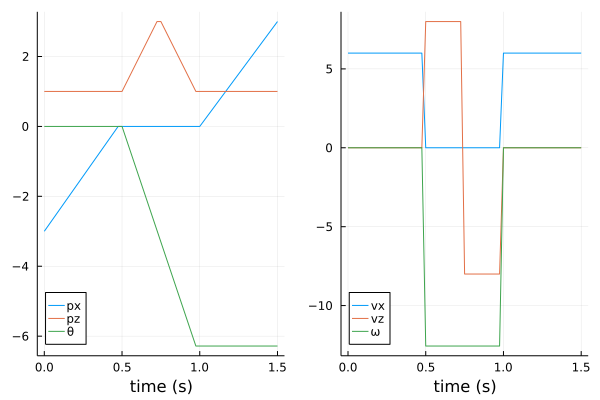

In [17]:
# Plot the reference trajectory and compare with the given plot
Xref = flip_reference()

# convert to static arrays and plot
Xref = [SVector{6}(Xref[i]) for i = 1:length(Xref)]
p = plot(layout=(1,2))
plot!(p[1], 0:dt:(N-1)*dt, Xref, inds=1:3, xlabel="time (s)", labels = ["px" "pz" "θ"], legend=:bottomleft)
plot!(p[2], 0:dt:(N-1)*dt, Xref, inds=4:6, xlabel="time (s)", labels = ["vx" "vz" "ω"], legend=:bottomleft)

In [18]:
@testset "flip reference" begin 
    Xref_ = flip_reference()
    @test length(Xref_) == 61
    Xref_ = hcat(Vector.(Xref_)...)
    @test mean(diff(Xref_[1,1:21])) ≈ 3/20 atol=1e-1
    @test mean(Xref_[4,1:20]) ≈ 6.0 atol=1e-1 
    @test mean(Xref_[1,21:40]) ≈ 0 atol=1e-1
    @test mean(diff(Xref_[1,41:end])) ≈ 3/20 atol=1e-1
    @test mean(Xref_[4,41:end]) ≈ 6.0 atol=1e-1 

    @test Xref_[3,1] ≈ 0 atol=1e-6
    @test Xref_[3,end] ≈ -2pi atol = 1e-6
    @test std(diff(Xref_[6,21:40])) < 0.1
    @test std(diff(Xref_[4,21:40])) < 0.1
end

Test Summary:  | Pass  Total
flip reference |   10     10


Test.DefaultTestSet("flip reference", Any[], 10, false, false)

## Part (d): Optimize the Flip Trajectory
Using the reference trajectory and the objective you specified in the previous part, construct a new problem and solve it with your iLQR solver. Use a simple hover trajectory as the initial guess.

In [19]:
# Solve for Xflip, Uflip, the optimized trajectories to flip the quadrotor

Uref = [copy(uhover) for i = 1:N-1]
Xflip,Uflip,Kflip,Pflip,iterflip = iLQR(x0,Uref,Xref,Uref);

iter     J           ΔJ        |d|         α
-----------------------------------------------
  1    6.477e+03   1.06e+04   1.33e+02   1.0000
  2    5.184e+03   1.16e+04   2.45e+02   0.5000
  3    1.564e+03   9.00e+03   2.69e+02   1.0000
  4    1.013e+03   2.46e+03   1.07e+02   0.2500
  5    6.208e+02   1.32e+03   6.78e+01   0.5000
  6    5.089e+02   4.91e+02   4.74e+01   1.0000
  7    3.488e+02   4.41e+02   5.71e+01   0.5000
  8    2.644e+02   2.00e+02   3.02e+01   0.5000
  9    2.030e+02   1.52e+02   2.47e+01   0.5000
 10    1.638e+02   1.26e+02   2.55e+01   0.5000
 11    1.409e+02   6.84e+01   2.66e+01   1.0000
 12    1.305e+02   2.22e+01   1.01e+01   1.0000
 13    1.299e+02   1.28e+00   2.24e+00   1.0000
 14    1.299e+02   1.91e-03   1.55e-01   1.0000
 15    1.299e+02   3.54e-04   7.04e-02   1.0000
 16    1.299e+02   7.80e-05   3.08e-02   1.0000
 17    1.299e+02   1.82e-05   1.47e-02   1.0000
 18    1.299e+02   4.47e-06   6.74e-03   1.0000
 19    1.299e+02   1.14e-06   3.31e-03   1.

In [20]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [21]:
visualize!(vis, model, dt*(N-1), Xflip)

## Part (e): Compare to TVLQR
iLQR generates a local linear feedback controller. As we saw in class, the backwardpass in iLQR is basically TVLQR with some extra terms. However, as our trajectory converges to a stationary point, these extra linear terms should go to zero. When iLQR exits, theses local feedback gains should closely match the result out of TVLQR. Using your code from the previous homework, generate a TVLQR solution for the optimized flip trajectory, using the same cost matrices used in your iLQR solver. They should match to reasonable numerical precision.

In [22]:
# TODO: Generate Klqr, Plqr, the feedback and cost-to-go matrices from TVLQR
#       to track the optimized flip trajectory

"""
time varying LQR given vectors of matrices A and B linearized about each point 

inputs:
    A - vector of A matrices       Vector{Matrix}
    B - vector of B matrices       Vector{Matrix}
    Q - state cost matrix          Matrix
    R - control cost matrix        Matrix
    Qf - terminal cost matrix      Matrix

outputs:
    K - feedback gain matrices     Vector{Matrix}
    P - cost to go hessians        Vector{Matrix}
"""
function tvlqr(A,B,Q,R,Qf)

    P = [zeros(nx,nx) for k = 1:N]
    K = [zeros(nu,nx) for k = 1:N-1]
    
    # TODO: ricatti recursion 
    
    return K,P
end

# dynamics jacobians for trajectory
A = [zeros(nx,nx) for k = 1:N-1]
B = [zeros(nx,nu) for k = 1:N-1]

# TODO: fill up A and B with dynamics jacobians about Xflip and Uflip
# hint: use the dynamics_jacobians function 


# call tvlqr
Klqr,Plqr = tvlqr(A,B,Q,R,Qf);

In [23]:
@testset "TVLQR vs iLQR" begin 
    @test maximum(norm.(Kflip - Klqr,Inf)) < 1e-3
    @test maximum(norm.(Pflip - Plqr,Inf)) < 1e-3
end

Test Summary: | Pass  Total
TVLQR vs iLQR |    2      2


Test.DefaultTestSet("TVLQR vs iLQR", Any[], 2, false, false)

## Part (f): Closed-Loop Tracking
Now that we've seen that the controller generated by iLQR is nearly identical to the TVLQR solution with the same cost matrices, let's use the iLQR gains to track our trajectory, and see how robust it is to wind gusts. We will produce this noise in the following way:

$$x_{k+1} = \operatorname{rk4}(x_k,u_k,dt) + [0,0,0,0.1\cdot\operatorname{randn}(3)]$$

In [24]:
using Random
"""
function for simulating with noise 

inputs:
    x0 - initial condition 
    Xflip - optimal flip trajectory from iLQR 
    Uflip - optimal flip control from iLQR 
    Kflip - feedback gain matrices from iLQR
    open_loop - bool, if true, use only Uflip as control, if false, use Uflip + feedback control

outputs:
    X - simulated X
    U - simulated U 
"""
function simulate_with_noise(x0,Xflip,Uflip,Kflip,open_loop)
    
    X = [zeros(nx) for i = 1:N]
    U = [zeros(nu) for i = 1:N-1]
    X[1] = copy(x0)
    
    Random.seed!(1)
    
    # TODO: simulate with added noise from wind 
    # use open_loop to determine what control you should apply 

    
    return X,U
end


Xlqr,Ulqr = simulate_with_noise(x0,Xflip,Uflip,Kflip,false);
Xopen,Uopen = simulate_with_noise(x0,Xflip,Uflip,Kflip,true);

In [25]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [27]:
# Simulate with LQR
visualize!(vis, model, dt*(N-1), Xlqr)

In [28]:
visualize!(vis, model, dt*(N-1), Xopen)

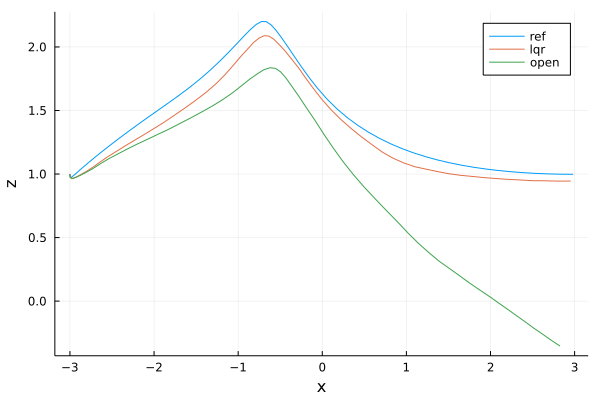

In [29]:
# Plot the trajectories
Xflip = SVector{nx}.(Xflip)
Xlqr = SVector{nx}.(Xlqr)
Xopen = SVector{nx}.(Xopen)
traj2(Xflip, label="ref")
traj2!(Xlqr, label="lqr")
traj2!(Xopen, label="open", ylabel="z")

In [33]:
@testset "open loop vs closed loop" begin 
    @test norm(Xflip[end][1:2] - Xlqr[end][1:2]) < 0.5
    @test norm(Xflip[end][1:2] - Xlqr[end][1:2]) > 0.0
    @test norm(Xflip[end] - Xlqr[end]) < norm(Xflip[end] - Xopen[end])
    @test norm(Xopen[end][1:2] - Xopen[end][1:2]) > 0.0
end

Test Summary:            | Pass  Total
open loop vs closed loop |    2      2


Test.DefaultTestSet("open loop vs closed loop", Any[], 2, false, false)